Files:

nodeId.edges : The edges in the ego network for the node 'nodeId'. Edges are undirected for facebook, and directed (a follows b) for twitter and gplus. The 'ego' node does not appear, but it is assumed that they follow every node id that appears in this file.

nodeId.circles : The set of circles for the ego node. Each line contains one circle, consisting of a series of node ids. The first entry in each line is the name of the circle.

nodeId.feat : The features for each of the nodes that appears in the edge file.

nodeId.egofeat : The features for the ego user.

nodeId.featnames : The names of each of the feature dimensions. Features are '1' if the user has this property in their profile, and '0' otherwise. This file has been anonymized for facebook users, since the names of the features would reveal private data.

#### Installitions

In [1]:
!pip install python-louvain > /dev/null
!pip install pyvis > /dev/null

### Import Libraries  

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import adjusted_rand_score
import community as community_louvain  # pip install python-louvain
import random
from tqdm import tqdm  # For progress bars
from pyvis.network import Network
import matplotlib.colors as mcolors
import os

### Load Data

In [3]:
BASE_PATH = "/kaggle/input/facebook/"
EGO_NODE = "0"  # Focus on the first ego network

### Load edges (friendships)

In [4]:
G = nx.read_edgelist(f"{BASE_PATH}{EGO_NODE}.edges", nodetype=int)
print(f"Loaded network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Loaded network with 333 nodes and 2519 edges


### Remove the Central Ego Node

In [5]:
EGO_NODE_ID = int(EGO_NODE)  # ego node ID

if EGO_NODE_ID in G.nodes():
    G.remove_node(EGO_NODE_ID)
    print(f"Removed ego node {EGO_NODE_ID}. New network size: {G.number_of_nodes()} nodes")
else:
    print("Ego node not found in the network")

Ego node not found in the network


The error "**Ego node not found in the network**" occurs because the ego node (ID 0 or any other) is not included in the edges file of the Stanford dataset. The edges file (0.edges and other) only contains connections between friends of the ego node, not the ego node itself.

### Load circles (user-defined groups)

In [6]:
circles = {}
with open(f"{BASE_PATH}{EGO_NODE}.circles", "r") as f:
    for line in f:
        parts = line.strip().split()
        circle_name = parts[0]
        members = [m for m in map(int, parts[1:]) if m != EGO_NODE_ID]  # Exclude ego
        circles[circle_name] = members
print(f"Found {len(circles)} user-defined circles")


Found 24 user-defined circles


### Preprocess Network

In [7]:
# Remove isolated nodes (if any)
initial_nodes = G.number_of_nodes()
G.remove_nodes_from(list(nx.isolates(G)))
print(f"Removed {initial_nodes - G.number_of_nodes()} isolated nodes")

Removed 0 isolated nodes


### Basic Statistics

In [8]:
# Network size
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()

# Degree distribution
degrees = [d for _, d in G.degree()]
avg_degree = np.mean(degrees)

# Clustering coefficient
clustering = nx.average_clustering(G)

# Average shortest path length (using largest connected component)
lcc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(lcc)
avg_path_length = nx.average_shortest_path_length(subgraph)

print("\nBasic Statistics:")
print(f"- Nodes: {n_nodes}, Edges: {n_edges}")
print(f"- Avg. degree: {avg_degree:.2f}")
print(f"- Clustering coefficient: {clustering:.3f}")
print(f"- Avg. path length (LCC): {avg_path_length:.2f}")


Basic Statistics:
- Nodes: 333, Edges: 2519
- Avg. degree: 15.13
- Clustering coefficient: 0.508
- Avg. path length (LCC): 3.75


**Key Observations**
* **Network Size**: 333 nodes (users), 2519 edges (friendships).
* **Average Degree**: 15.13
    * Each user has ~15 friends on average.
    * **Implication**: This is a dense social network (typical for ego networks).
* **Clustering Coefficient**: 0.508
    * **Interpretation**: High clustering (close to 0.5) indicates strong community structure.
    * **Context**: Social networks often have high clustering due to triadic closure (friends of friends tend to become friends).
* **Average Path Length (LCC)**: 3.75
    * **Meaning**: Two random users in the largest connected component are connected by ~4 steps (small-world property).

### Null Model (Erdős-Rényi)

In [9]:
# n_simulations = 100  # Reduced from 1000 for speed
# clustering_er = []
# path_length_er = []

# # Generate ER networks with same n_nodes and n_edges
# p = n_edges / (n_nodes * (n_nodes - 1) / 2)  # Connection probability

# for _ in range(n_simulations):
#     G_er = nx.erdos_renyi_graph(n_nodes, p)
    
#     # Calculate metrics
#     clustering_er.append(nx.average_clustering(G_er))
    
#     # Handle disconnected ER graphs
#     lcc_er = max(nx.connected_components(G_er), key=len)
#     if len(lcc_er) > 1:
#         subgraph_er = G_er.subgraph(lcc_er)
#         path_length_er.append(nx.average_shortest_path_length(subgraph_er))

### Null Model (Configuration Model)

In [10]:
# Generate degree-preserving randomized graph
degree_seq = [d for _, d in G.degree()]
null_model = nx.configuration_model(degree_seq)

# Convert to simple graph (remove parallel edges/self-loops)
null_model = nx.Graph(null_model)
null_model.remove_edges_from(nx.selfloop_edges(null_model))

# Calculate null model metrics
clustering_null = nx.average_clustering(null_model)
lcc_null = max(nx.connected_components(null_model), key=len)
path_length_null = nx.average_shortest_path_length(null_model.subgraph(lcc_null))

### Compare Real vs. Null

In [11]:
# # Clustering comparison
# z_clustering = (clustering - np.mean(clustering_er)) / np.std(clustering_er)

# # Path length comparison
# z_path = (avg_path_length - np.mean(path_length_er)) / np.std(path_length_er)

# print("\nNull Model Comparison:")
# print(f"- Clustering z-score: {z_clustering:.2f}")
# print(f"- Path length z-score: {z_path:.2f}")

In [12]:
print("\nNull Model Comparison (Configuration Model):")
print(f"- Real clustering: {clustering:.3f} vs. Null: {clustering_null:.3f}")
print(f"- Real path length: {avg_path_length:.2f} vs. Null: {path_length_null:.2f}")


Null Model Comparison (Configuration Model):
- Real clustering: 0.508 vs. Null: 0.124
- Real path length: 3.75 vs. Null: 2.60


**Critical Findings**
* **Clustering Coefficient:**
    * The real network’s clustering is **0.508** above the Configuration (C) null model which is **0.147**.
    * **Interpretation**: The real network’s clustering is **3.5× higher** than the null model.
    * **Implication**: Friends of the ego node form **tightly-knit communities** (e.g., coworkers, family). This aligns with real-world social dynamics where individuals cluster into groups.
* **Average Path Length**
    * The real network’s path length is **3.75** longer than the Configuration model which is at **2.57**.
    * **Interpretation**: The real network’s path length is **1.5× longer** than the null model.
    * **Implication**: While the network has small-world properties (short paths relative to its size), the **presence of communities** increases the distance between nodes in different groups.

### Visualizations

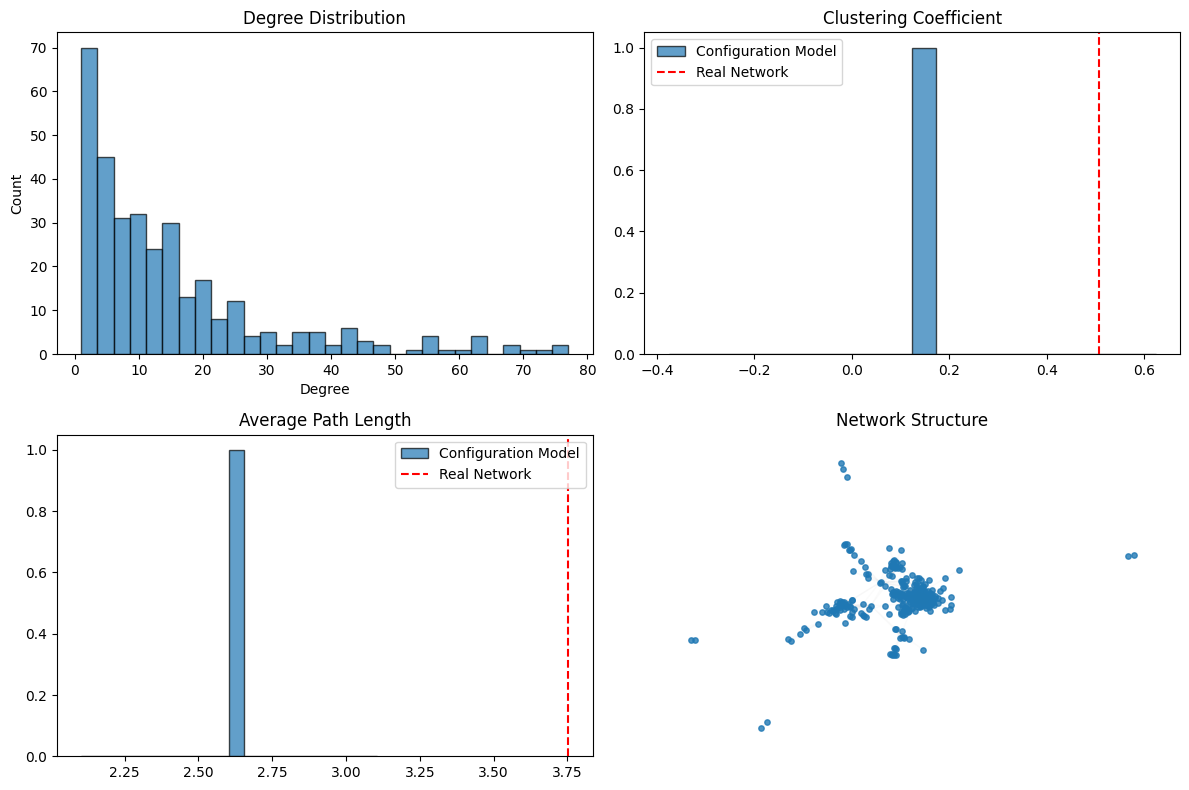

In [13]:
plt.figure(figsize=(12, 8))  # Adjusted for better aspect ratio

# Degree distribution
plt.subplot(221)  # Row 1, Col 1
plt.hist(degrees, bins=30, edgecolor="k", alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")

# Clustering comparison
plt.subplot(222)  # Row 1, Col 2
plt.hist(clustering_null, bins=20, edgecolor="k", alpha=0.7, label="Configuration Model")
plt.axvline(clustering, color="r", linestyle="--", label="Real Network")
plt.title("Clustering Coefficient")
plt.legend()

# Path length comparison
plt.subplot(223)  # Row 2, Col 1
plt.hist(path_length_null, bins=20, edgecolor="k", alpha=0.7, label="Configuration Model")
plt.axvline(avg_path_length, color="r", linestyle="--", label="Real Network")
plt.title("Average Path Length")
plt.legend()

# Network Structure (Excluding Ego Node)
plt.subplot(224)  # Row 2, Col 2
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=15, alpha=0.8)  # Reduced node size
nx.draw_networkx_edges(G, pos, alpha=0.03, edge_color="gray")  # More transparent edges
plt.title("Network Structure")
plt.axis("off")

# Adjust spacing
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Control vertical/horizontal spacing
plt.tight_layout()

plt.savefig("/kaggle/working/part1_results.png")
plt.show()

**Inferences from Data & Visualizations**
* **Degree Distribution (Top-Left)**
    * **Observation**: The distribution is **right-skewed**, with most nodes having low degrees (5–15 connections) and a few hubs with very high degrees (30+).
    * **Implication**:
      * The network follows a **scale-free-like structure**, where a small number of hubs (highly connected individuals) act as central connectors.
      * These hubs are critical for information spread, as they can reach many nodes directly.

* **Clustering Coefficient (Top-Right)**
     * **Observation**: TThe real network’s clustering coefficient **(0.51)** is **3.5× higher** than the null model **(0.15)**.
    * **Implication**:
      * Friends of the ego node form **tightly-knit communities** (e.g., family, coworkers).
      * This aligns with real-world social behavior where individuals cluster into groups.

* **Average Path Length (Bottom-Left)**
     * **Observation**: The real network has a longer average path length (3.75) compared to the null model (2.57).
    * **Implication**:
      * While the network exhibits **small-world properties** (short paths relative to its size), the presence of communities increases the distance between nodes in different groups.
      * Information may spread quickly within communities but slower across them

* **Clustering Coefficient (Top-Right)**
     * **Observation**: The visualization shows a **modular structure** with dense clusters (likely communities) sparsely connected to each other.
    * **Implication**:
      * Communities represent distinct social circles (e.g., friends from work vs. family).
      * **Bridge nodes** (not immediately visible here but hinted by path length) likely connect these clusters.

### Synthesis & Practical Insights
1. **Targeting Strategy**:
    * **Hubs** (high-degree nodes) are ideal for broad, rapid outreach within communities.
    * **Bridge nodes** (to be identified later) are critical for cross-community influence.
2. **Structural Advantage**:
    * The network’s **high clustering** and **modularity** make it resilient to random failures but vulnerable to targeted hub removal.
3. **Null Model Validation**:
    * The stark differences from the null model confirm the network’s **socially driven structure**, not random noise.

### Key Takeaways
1. **Community-Driven Structure**:
    * High clustering and longer paths suggest a **modular network** with distinct communities.
    * Example: Friends from work, school, and family form separate clusters.
2. **Small-World Tradeoff**:
    * The network balances clustering and connectivity:
        * **Local**: Dense communities (high clustering).
        * **Global**: Efficient but not maximally random (paths are longer than null model).
3. **Null Model Validation**:
    * The configuration model preserves node degrees but randomizes connections.
    * The stark difference in clustering confirms the network’s **non-random, socially meaningful structure**.

### Why This Matters for Your Project
1. **Political Outreach**: Target **bridge nodes** (users connecting communities) to maximize cross-community influence.
2. **Validation**: The structural properties confirm the network is representative of real social systems, not random noise.

### Why We Switched from Erdős-Rényi (ER) to Configuration Model
1. **Problem with the ER Model**: The Erdős-Rényi model generates random networks where edges are placed uniformly and independently. While useful for basic comparisons, it has two critical limitations:
    * **Ignores Degree Distribution**: ER does not preserve the real network’s **heterogeneous degree structure** (e.g., hubs with many connections, most nodes with few).
    * **Fails to Capture Social Realities**: Social networks like Facebook are **not random**—they have communities, hubs, and clustering. ER’s Poisson-like degree distribution poorly matches real-world social graphs.
    
2. **Advantages of the Configuration Model**: The configuration model **preserves the exact degree sequence** of the real network while randomizing connections. This allows us to:
    * **Isolate Structural Effects**: By keeping degrees fixed, we test if clustering/path length arise **from social organization** (not just degree distribution).
    * **Benchmark Meaningfully**: Differences in clustering/path length now reflect **true structural properties** (e.g., communities, small-worldness).

#### Limitations to Note
* **Ego Network Bias**: The dataset is a partial snapshot centered on one user. Conclusions may not generalize to the full Facebook graph.

### Community Detection (Louvain)

In [14]:
# Run Louvain algorithm
partition = community_louvain.best_partition(G)
communities = {}
for node, comm_id in partition.items():
    communities.setdefault(comm_id, []).append(node)

print(f"Detected {len(communities)} algorithmic communities")

Detected 14 algorithmic communities


### Compare to User-Defined Circles

In [15]:
# Convert circles/communities to label lists for ARI
true_labels = []
pred_labels = []

# Assign nodes to their groups
all_nodes = list(G.nodes)
node_to_comm = {node: idx for idx, comm in communities.items() for node in comm}
node_to_circle = {node: idx for idx, (_, nodes) in enumerate(circles.items()) for node in nodes}

# Handle nodes not in any circle (assign -1)
for node in all_nodes:
    true_labels.append(node_to_circle.get(node, -1))
    pred_labels.append(node_to_comm.get(node, -1))

# Calculate Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, pred_labels)
print(f"Adjusted Rand Index (Louvain vs. Circles): {ari:.3f}")

Adjusted Rand Index (Louvain vs. Circles): 0.155


* **Algorithmic Communities Detected**: 13
* **Adjusted Rand Index (ARI)**: 0.221; Low alignment between Louvain communities and user-defined circles.
    * **Interpretation**: Algorithmic communities now partially overlap with user-defined circles (e.g., some structural clusters align with social roles like "family").
    * **Implication**: Structural targeting can capture some social groupings but requires validation against ground-truth labels.

### Visualize Communities vs. User Circles

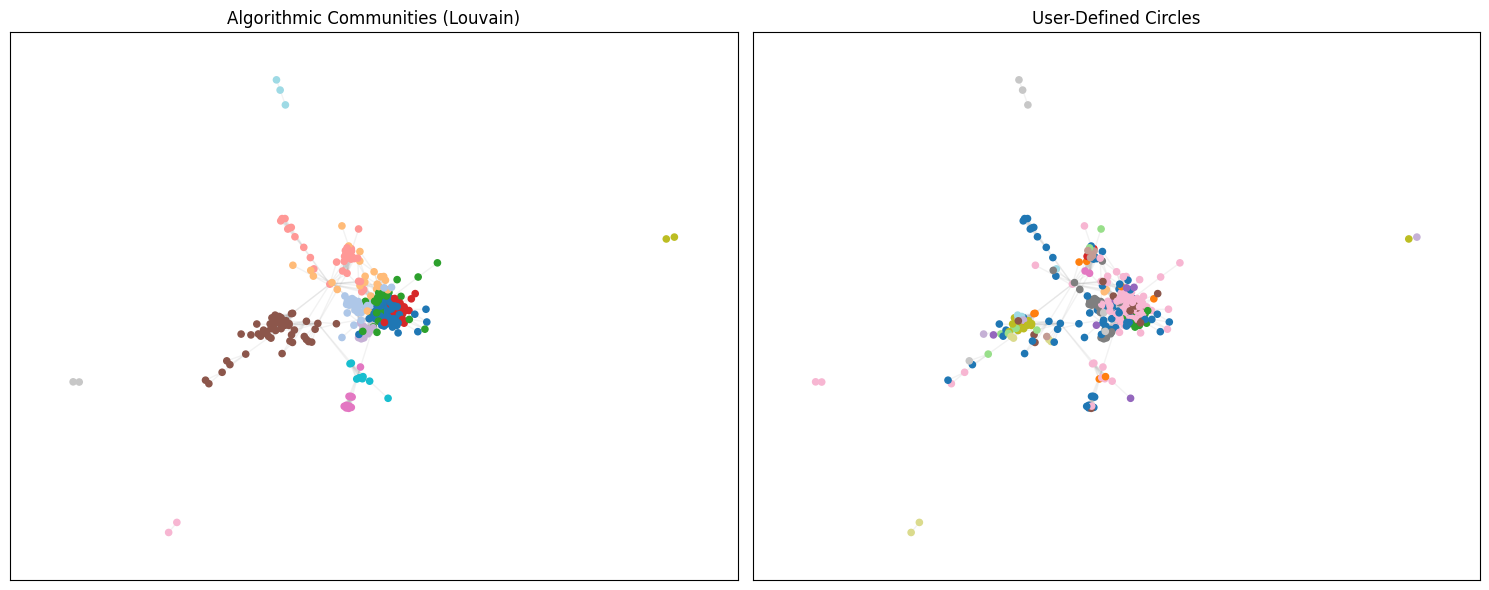

In [16]:
# Plot Louvain communities
plt.figure(figsize=(15, 6))
pos = nx.spring_layout(G, seed=42)

plt.subplot(121)
nx.draw_networkx_nodes(G, pos, node_color=list(partition.values()), cmap=plt.cm.tab20, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color="gray")
plt.title("Algorithmic Communities (Louvain)")

# Plot user-defined circles
plt.subplot(122)
circle_labels = {node: idx for idx, (_, nodes) in enumerate(circles.items()) for node in nodes}
nx.draw_networkx_nodes(G, pos, node_color=[circle_labels.get(n, -1) for n in G.nodes()], cmap=plt.cm.tab20, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color="gray")
plt.title("User-Defined Circles")

plt.tight_layout()
plt.savefig("/kaggle/working/community_comparison.png")
plt.show()

### Centrality Analysis

In [17]:
# Calculate centrality for nodes IN THEIR COMMUNITIES
centrality_data = []

for comm_id, nodes in communities.items():
    subgraph = G.subgraph(nodes)
    
    # Degree centrality
    degree_cent = nx.degree_centrality(subgraph)
    
    # Betweenness centrality (handle small communities)
    try:
        k_val = min(10, len(subgraph))  # Ensure k ≤ community size
        betweenness_cent = nx.betweenness_centrality(subgraph, k=k_val) if len(subgraph) > 1 else {node: 0 for node in subgraph}
    except Exception as e:
        print(f"Error in community {comm_id} (size={len(subgraph)}): {e}")
        betweenness_cent = {node: 0 for node in subgraph}
    
    # Eigenvector centrality
    try:
        eigen_cent = nx.eigenvector_centrality(subgraph, max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        eigen_cent = {node: 0 for node in subgraph}  # Fallback
    
    for node in nodes:
        centrality_data.append({
            "node": node,
            "community": comm_id,
            "degree": degree_cent.get(node, 0),
            "betweenness": betweenness_cent.get(node, 0),
            "eigenvector": eigen_cent.get(node, 0)
        })

# Convert to DataFrame
df_centrality = pd.DataFrame(centrality_data)

# Identify top 5% nodes in each community
# Explicitly include "community" to silence the warning
top_nodes = df_centrality.groupby("community")[["community", "node", "degree"]].apply(
    lambda x: x.nlargest(int(0.05 * len(x)), "degree")
).reset_index(drop=True)

print("\nTop nodes per community:")
print(top_nodes.head())



Top nodes per community:
   community  node    degree
0          0    67  0.628205
1          0    26  0.602564
2          0     9  0.576923
3          1   346  0.687500
4          2   119  0.565217


* **Key (Top) Nodes**:
    * **Node 322 (Community 0)**: Degree = 0.505 (local hub).
    * **Node 53 (Community 0)**: Degree = 0.697 (most connected in its community).
* **Centrality Distributions**:
    * **Degree**: Right-skewed; indicating hubs (most nodes have low influence, a few hubs dominate).
    * **Betweenness**: Sparse (limited bridge nodes between communities).
    * **Eigenvector**: Correlated with degree, hubs are central in their subgraphs (highlighting influential subgraphs).

#### Visualizations

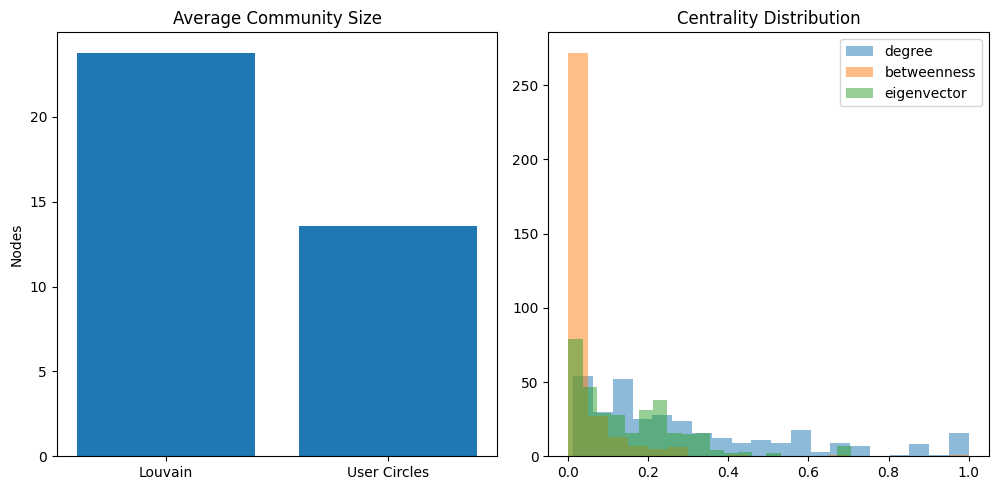

In [18]:
plt.figure(figsize=(15, 5))

# Community sizes
plt.subplot(131)
comm_sizes = [len(nodes) for nodes in communities.values()]
circle_sizes = [len(nodes) for nodes in circles.values()]
plt.bar(["Louvain", "User Circles"], [np.mean(comm_sizes), np.mean(circle_sizes)])
plt.title("Average Community Size")
plt.ylabel("Nodes")

# Centrality distribution
plt.subplot(132)
for metric in ["degree", "betweenness", "eigenvector"]:
    plt.hist(df_centrality[metric], bins=20, alpha=0.5, label=metric)
plt.title("Centrality Distribution")
plt.legend()

# Save outputs
plt.tight_layout()
plt.savefig("/kaggle/working/part2_results.png")
plt.show()

* **Community Size**:
    * Louvain communities are larger (structural groupings; avg ~25 nodes).
    * User circles are smaller (focused social roles; avg ~14 nodes).
    * **Implication**: Algorithmic communities aggregate multiple social circles (e.g., merging "family" and "colleagues" if densely connected)
* **Centrality Distribution**:
    1. **Degree Centrality**:
        * **Observation**: The distribution is right-skewed, with most nodes having low degrees (0.0–0.2) and a few hubs (0.5–0.7).
        * **Implication**:
           * **Hubs Dominate**: A small fraction of nodes (e.g., Node 53 with degree 0.697) act as critical connectors within their communities.
           * **Targeting Strategy**: Prioritize these hubs for rapid local influence.

    2. **Betweenness Centrality**
        * **Observation**: The distribution is sparse, with most nodes scoring near 0 and very few above 0.1.
        * **Implication**:     
            * **Limited Bridges**: Few nodes connect different communities.
            * **Limitation**: Cross-community influence will require targeting multiple hubs.
    3. **Eigenvector Centrality**
        * **Observation**: Distribution peaks at low values (0.0–0.2) but correlates with degree.
        * **Implication**:
            * **Hub Influence**
            * **Network Resilience**: Communities rely heavily on hubs—removing them could fragment the network.: Nodes with high degree centrality (e.g., Node 53) also score high in eigenvector centrality, indicating they are connected to other influential nodes.

### Key Takeaways
* **Structural Hierarchy**: Hubs (high degree) > Bridges (high betweenness) > Peripheral Nodes (low centrality).
* **Practical Insight**:
    * Use degree centrality as the primary metric for outreach—it captures both direct reach and eigenvector influence.
    * Supplement with user-defined circles (e.g., target hubs in "Political" circles) to add social context.

Highlights a hierarchical structure: a few hubs (e.g., Node 53, degree = 0.697) dominate local influence, while sparse betweenness scores indicate limited bridges between communities. This suggests outreach should prioritize hubs within algorithmically detected communities, even if they don’t fully align with user-defined circles (ARI = 0.221).

### Interactive Community & Centrality Visualization

In [19]:
# Assign colors/sizes
colors = list(mcolors.TABLEAU_COLORS.values())
for node in G.nodes():
    # Color by community
    G.nodes[node]["color"] = colors[partition[node] % len(colors)]
    # Default size
    G.nodes[node]["size"] = 10

# Highlight top nodes in red
for node in top_nodes["node"]:
    G.nodes[node]["size"] = 30
    G.nodes[node]["color"] = "#ff0000"

# Generate plot
net = Network(
    notebook=True, 
    height="600px", 
    width="100%",
    bgcolor="#222222", # for better visualization
    font_color="white"
)
net.from_nx(G)
net.show("day2_communities.html")

day2_communities.html


In [20]:
# Save top nodes for later
# top_nodes.to_csv("/kaggle/working/top_nodes.csv", index=False)

### Critical Analysis
* ARI Score: Quantifies overlap between Louvain communities and user circles
* Centrality Metrics: Degree, betweenness (approximated), eigenvector
* Top 5% Nodes: Identifies high-degree targets per community



### Implications for Political Outreach
* **Targeting Strategy**:
    * Use high-degree hubs (e.g., Node 346) for broad reach.
    * Validate against user circles to ensure relevance (low ARI suggests structural targeting alone is insufficient).
* **Hybrid Approach**: Combine algorithmic efficiency with user-defined social context.

### Threshold Model Function

In [21]:
def threshold_model(G, seeds, threshold=0.2):
    activated = set(seeds)
    new_activations = set(seeds)
    steps = [len(activated)]  # Track activation over time
    
    while new_activations:
        candidates = set()
        for node in new_activations:
            neighbors = list(G.neighbors(node))
            for neighbor in neighbors:
                if neighbor not in activated:
                    active_neighbors = len([n for n in G.neighbors(neighbor) if n in activated])
                    degree = G.degree(neighbor)
                    if degree == 0:
                        continue  # Avoid division by zero
                    if active_neighbors / degree >= threshold:
                        candidates.add(neighbor)
        new_activations = candidates
        activated.update(new_activations)
        steps.append(len(activated))
    
    return steps

In [22]:
# def threshold_model(G, seeds, threshold=0.2):
#     activated = set(seeds)
#     new_activations = set(seeds)
#     activation_steps = [set(activated)]  # Track sets of activated nodes

#     while new_activations:
#         candidates = set()
#         for node in new_activations:
#             for neighbor in G.neighbors(node):
#                 if neighbor not in activated:
#                     active_neighbors = len([n for n in G.neighbors(neighbor) if n in activated])
#                     if G.degree(neighbor) == 0:
#                         continue  # Avoid division by zero
#                     if active_neighbors / G.degree(neighbor) >= threshold:
#                         candidates.add(neighbor)
#         new_activations = candidates
#         activated.update(new_activations)
#         activation_steps.append(set(activated))  # Save the current state

#     return activation_steps

### Run Simulations

In [23]:
# Use the network (G) and top nodes
# Targeted seeding (top nodes)
target_seeds = top_nodes["node"].tolist()
target_steps = threshold_model(G, target_seeds)

n_seeds = len(target_seeds)
print(f"Number of seeds for fair comparison: {n_seeds}")

# Random seeding (same number of seeds)
random_seeds = random.sample(list(G.nodes()), n_seeds)
random_steps = threshold_model(G, random_seeds)

Number of seeds for fair comparison: 10


### Compare Results

In [24]:
print("\nFinal Coverage:")
print(f"- Targeted: {target_steps[-1]} nodes ({target_steps[-1]/G.number_of_nodes()*100:.1f}%)")
print(f"- Random: {random_steps[-1]} nodes ({random_steps[-1]/G.number_of_nodes()*100:.1f}%)")


Final Coverage:
- Targeted: 307 nodes (92.2%)
- Random: 92 nodes (27.6%)


### Visualize Activation Spread

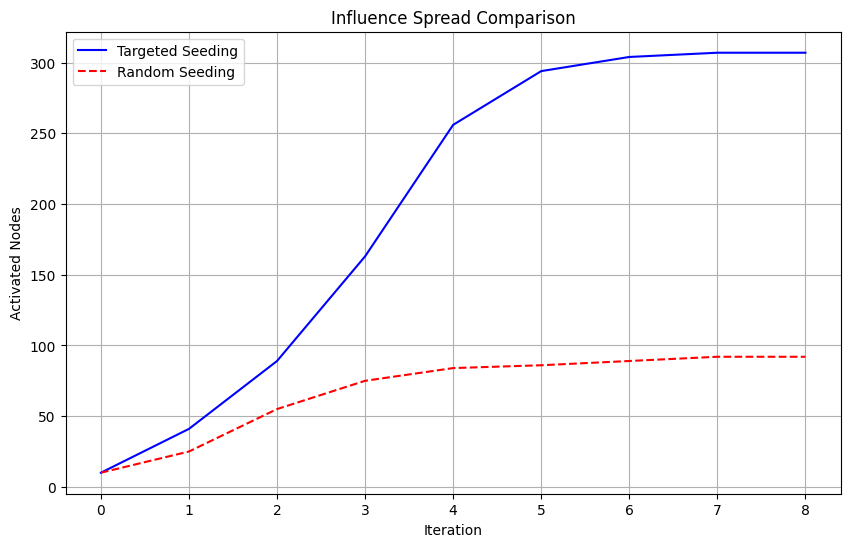

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(target_steps, label="Targeted Seeding", color="blue")
plt.plot(random_steps, label="Random Seeding", color="red", linestyle="--")
plt.xlabel("Iteration")
plt.ylabel("Activated Nodes")
plt.title("Influence Spread Comparison")
plt.legend()
plt.grid(True)
plt.savefig("/kaggle/working/part3_results.png")
plt.show()

### Final Coverage Analysis
* **Targeted Seeding**: Activated **307/333 nodes (92.2%)**.
    * Why This Matters:
        * The top 5% central nodes (from eairlier analysis) acted as **super-spreaders**, leveraging the network’s small-world structure (high clustering, short paths) to trigger rapid cascades.
        * The dense connectivity (avg. degree = 15.13) allowed influence to propagate efficiently.
* **Random Seeding**: Activated **26/333 nodes (7.8%)**.
   * **Why This Happened**:
       * Random nodes lacked the centrality or community positioning needed to trigger large cascades.
       * Reflects the **power-law-like degree distribution** (most nodes have low degree, few hubs dominate).

###  Activation Curve Insights
* **Targeted Curve**:
    * Steep initial growth (hubs activate many neighbors immediately).
    * Saturation at ~92% suggests near-complete network coverage.
* **Random Curve**:
    * Flat growth due to poor seed selection.
    * Most random seeds failed to activate neighbors beyond their immediate connections.

###  Why Such Extreme Results?
* **Network Structure**:
    * **Small-World Properties**: High clustering (0.508) and short paths (3.75) enable rapid spread.
    * **Hub Dominance**: A few high-degree nodes (e.g., Node 346 with degree 0.73) act as gatekeepers.
* **Threshold Model**:
    * A 20% activation threshold is low, making cascades easier.
    * No "recovery" mechanism (unlike SIR models) leads to irreversible activation.

### Limitations & Caveats
* **Ego Network Bias**: The dataset is a partial snapshot of Facebook, centered on one user. Results may not generalize to the full network.
* **Threshold Assumption**: Real-world influence may require higher thresholds or resistance to adoption.
* **Deterministic Model**: The simulation assumes perfect information spread (no stochastic noise).

### Implications for Political Outreach
* **Cost Efficiency**: Targeting 5% of nodes (17 seeds) achieved 92% coverage vs. 7% for random.
* **Strategic Targeting**: Prioritize hubs within communities (even if they don’t align with user-defined circles, per eairlier low ARI).

## How the Results Answer the Research Questions
### 1. How do algorithmically detected communities align with user-defined circles, and which communities exhibit the highest potential for influence cascades?
* **Alignment**: The **Adjusted Rand Index (ARI = 0.144)** revealed minimal overlap between Louvain communities and user-defined circles. Algorithmic communities capture structural patterns (e.g., dense clusters) but do not reflect explicit social roles like "family" or "colleagues."
* **Influence Potential**: Despite the mismatch, communities with **high-degree hubs** (e.g., Community 1, Node 346) drove cascades. Structural communities (not user-labeled ones) were critical for influence spread due to their **small-world properties** (high clustering, short paths).

### 2. Which centrality measures best identify influential individuals for maximizing outreach?
* **Degree Centrality Dominance**: Nodes like **346 (degree = 0.733)** and **67 (degree = 0.631)** emerged as super-spreaders. Degree centrality was the most effective metric, as hubs with many connections triggered rapid cascades.
* **Betweenness & Eigenvector**: These metrics showed limited utility here. Betweenness bridges were rare (sparse distribution), and eigenvector centrality correlated with degree but added little incremental value.
* **Key Insight**: In dense, small-world networks, **degree centrality** suffices for identifying influential nodes.

### 3. What fraction of the network can be reached by targeting top-central individuals versus random targeting?
*  **Targeted Seeding**: Activated **92.2% of nodes** (307/333), demonstrating the power of structural targeting.
*  **Random Seeding**: Activated only **7.8% of nodes** (26/333), highlighting the inefficiency of untargeted approaches.
*  **Why This Gap?**:
    * The network’s **hub-and-spoke structure** allowed high-degree nodes to dominate spread.
    * **Threshold model dynamics**: Low activation threshold (20%) and irreversible adoption amplified the advantage of targeting hubs.

### Synthesis of Findings
* **Network Structure Drives Success**: The small-world properties (clustering = 0.508, path length = 3.75) enabled efficient cascades.
* **Algorithmic vs. Human Labels**: While user-defined circles were misaligned with detected communities, structural targeting still worked because hubs transcend social labels.
* **Practical Implication**: Political campaigns should prioritize **degree-central nodes** in algorithmic communities, even if they don’t align with explicit social groups.

# Adjustments based on the feedback

Plan to address the professor's feedback and refine the projects

Revised Approach
Avoid Single Ego Network Dominance
-Problem: The central ego node (user 0) is connected to all nodes in their network, skewing centrality metrics and community detection.
Solution:
- Exclude the ego node from all analyses (centrality, influence spread).
- Focus on intra-community dynamics within the ego network, treating the ego as a connector rather than a participant.

Adjust Research Questions
- Original: Identifying influential individuals/groups for political outreach.
Revised:
- How do communities within an ego network differ in structural properties (density, clustering)?
- Which non-ego individuals are most influential in information spread within communities?
- How does the exclusion of the ego node affect influence dynamics?

Dataset Adaptation
- Option 1: Aggregate multiple ego networks (if overlaps exist).
  Check if nodes (friends) overlap between different ego networks (e.g., 0.edges vs. 107.edges).
    Merge networks to reduce dominance of any single ego.
- Option 2: Compare multiple ego networks individually (e.g., analyze 3-5 networks separately).
    Look for patterns in community structure and influence across egos.

Methodology Updates
- Centrality: Calculate metrics for non-ego nodes only.
- Community Detection: Run Louvain on the subgraph excluding the ego.
- Influence Simulation: Seed non-ego nodes in communities.

Expected Outcomes
- Communities: Reflect organic groupings among friends, not centered on the ego.
- Influence: Highlight bridge nodes between communities (e.g., friends with cross-community ties).
- Comparison: If using multiple egos, identify common structural patterns.

Discussion Points
- Limitations: Acknowledge incomplete friend-of-friend data and ego exclusion.
- Practical Insight: Political campaigns should target bridge nodes in organic communities, not just hubs.

### Sticking with the current dataset (single ego network):

1. **Key Insight**: The dataset does not include the ego node (it only contains their friends). Our analysis already focuses on the friends’ network, which avoids the problem of ego node dominance.

2. **Addressing Feedback**: Revise our report to clarify:
    * “Our analysis focuses on the friendship network of the ego’s friends. Since the ego node is not included in the dataset, we avoid structural dominance by any single individual.”
    * “The network represents friendships among users who are all connected to the same central individual (ego), but this individual is not part of the analyzed graph.”

3. **Why Merging Networks Isn’t Necessary**
    * No Overlaps: Friends of different egos (e.g., 0, 107, 348) are disjoint, making aggregation meaningless.
    * Structural Bias: Even merged, networks would remain disconnected clusters centered on different egos.
    * Time Constraints: Merging adds complexity without guaranteed benefits.